In [1]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import scipy
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, Dropout

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
SEED = 145
set_seed(seed=SEED)

Random seed 145 has been set.


In [6]:
#@title Data retrieval
fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [7]:
# @title Data loading

alldat = np.load(fname, allow_pickle=True)['dat'] # Total: 4 patients

# Select just one of the recordings here. This is block 1, subject 3.
dat = alldat[0][2]

print(dat.keys())

dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [8]:
def select_brain_regions(data, selected_BA):
    '''
    args:
        data(dict): dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY',
                                'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
        selected_BA(list): a list of Brodmann Area numbers
    retuns:
        new_data(dict): dict_keys(['V', 'cursorX', 'cursorY'])
    '''

    Brodmann_Area = data['Brodmann_Area']
    BA_num = [ int(x[14:]) for x in Brodmann_Area ] # get Brodmann Area number
    is_selected = [i in selected_BA for i in BA_num]
    new_V = data['V'][:,is_selected].astype(np.float32) # ECog voltage (time x channel)
    new_data = {'V': new_V, 'cursorX': data['cursorX'], 'cursorY': data['cursorY'] }

    return new_data

In [9]:
# Get data from the electrodes in somatosensory and motor areas

# Brodmann area location and function
# https://www.simplypsychology.org/brodmann-areas.html
# Brodmann areas 1, 2 & 3 : Primary somatosensory Cortex (postcentral gyrus)
# Brodmann area 4 : Primary Motor Cortex (precentral gyrus)
# Brodmann area 5 : Somatosensory Association Cortex (superior parietal lobule)
# Brodmann area 6 : Premotor Cortex and Supplementary Motor Cortex
# Brodmann area 7 : Somatosensory Association Cortex
# Brodmann area 8 : Frontal eye fields

selected_BA = np.arange(9) # select Brodmann area 1 to 8
dat = select_brain_regions(dat, selected_BA)


In [10]:
def filter_signal(data, freq_band, sample_rate, order = 4):
    '''
    args:
        data(dict): dict_keys(['V', 'cursorX', 'cursorY'...)
        freq_band (list): frequence band for filtering ([lowcut, highcut])
        sample_rate (int): sample rate (in Hz)
        order (int): 4 (default)
    retuns:
        new_data(dict): dict_keys(['filtered_V', 'cursorX', 'cursorY'])
    '''
    nyquistFreq = sample_rate*0.5
    # The Nyquist frequency is the highest frequency that equipment of a given sample rate can reliably measure,
    # one-half the given sample rate.
    low  = freq_band[0] / nyquistFreq
    high = freq_band[1] / nyquistFreq

    b, a = scipy.signal.butter(order, [low, high], btype='bandpass')

    V = data['V']
    nt, nchan = V.shape

    new_V = np.zeros_like(V)
    for i in range(nchan):
        new_V[:,i] = scipy.signal.filtfilt(b, a, V[:, i])

    new_data = {'V': new_V, 'cursorX': data['cursorX'], 'cursorY': data['cursorY'] }

    return new_data

In [11]:
# Filter ecog
# Beta rhythms (13-30 Hz)
sample_rate = 1000
freq_band = [10, 50]
dat = filter_signal(dat, freq_band, sample_rate)


In [12]:
def create_snips(data, window_len, stride_len, sample_rate):
    '''
    args:
        data(dict): dict_keys(['V', 'cursorX', 'cursorY'])
        window_len (int): length of time window (in ms)
        stride_len (int): length of stride (in ms)
        sample_rate (int): sample rate (in Hz)

    returns:
        X: neural data (a 3D matrix, # of samples x # of bin in window_len  x # of channel)
        Y: label (a 2D matrix, # of smaples x # of coordinates)
    '''
    bin_size = 1000/sample_rate # ms
    V = data['V'].astype(np.float32) #ECoG recording (time x channel)
    nt, nchan = V.shape
    num_bin_window = int(window_len/bin_size)
    assert len(data['cursorX']) == nt
    assert len(data['cursorX']) == len(data['cursorY'])
    indices = [(i, i + num_bin_window) for i in list(range(0, nt - num_bin_window +1, int(stride_len/bin_size)))]

    # normalize cursor X and Y
    normalized_cursorX = data['cursorX']/np.max(data['cursorX'])
    normalized_cursorY = data['cursorY']/np.max(data['cursorY'])

    num_samples = len(indices)
    #Initialize X and Y matrix
    X = np.empty([num_samples,num_bin_window,nchan])
    X[:] = np.NaN
    Y = np.empty([num_samples,2])
    Y[:] = np.NaN

    for i, indx in enumerate(indices):
        X[i,:,:] = V[indx[0]:indx[1], :]
        Y[i,0] = normalized_cursorX[indx[1], 0]
        Y[i,1] = normalized_cursorY[indx[1], 0]

    return X, Y

In [13]:
#screen refresh rate ~ 20Hz. So stride > 50ms.
sample_rate = 1000 # (in Hz)
window_len = 500 # (in ms)
stride_len = 100 # (in ms)
num_overlapping_bin = int(window_len/stride_len)
X, Y = create_snips(dat, window_len, stride_len, sample_rate)

In [14]:
X.shape

(1339, 500, 33)

**Splitting the data into train, test and validation sets - 80% train, 10% test and 10% validation. Then, doing a 10 fold Cross Validation...so in the first fold, for example, 0-10% is validation, 10-20% is testing, and 20-100% is training.**

In [15]:
valid_range_all=[[0,.1],[.1,.2],[.2,.3],[.3,.4],[.4,.5],
                     [.5,.6],[.6,.7],[.7,.8],[.8,.9],[.9,1]]
testing_range_all=[[.1,.2],[.2,.3],[.3,.4],[.4,.5],[.5,.6],
                     [.6,.7],[.7,.8],[.8,.9],[.9,1],[0,.1]]
#Note that the training set is not aways contiguous. For example, in the second fold, the training set has 0-10% and 30-100%.
#In that example, we enter of list of lists: [[0,.1],[.3,1]]
training_range_all=[[[.2,1]],[[0,.1],[.3,1]],[[0,.2],[.4,1]],[[0,.3],[.5,1]],[[0,.4],[.6,1]],
                       [[0,.5],[.7,1]],[[0,.6],[.8,1]],[[0,.7],[.9,1]],[[0,.8]],[[.1,.9]]]

num_folds=len(valid_range_all) #Number of cross validation folds

#R2 values
mean_r2_lstm=np.empty(num_folds)

In [16]:
#Actual data
y_test_all=[]
y_train_all=[]
y_valid_all=[]

#Test predictions
y_pred_lstm_all=[]
dec_error_all = []

#Training predictions
y_train_pred_lstm_all=[]

#Validation predictions
y_valid_pred_lstm_all=[]

t1 = time.time()  # If I want to keep track of how much time has elapsed

num_examples = len(X)  # number of examples
print(num_examples)


1339


In [17]:
class LSTMRegression(object):

    """
    Class for the LSTM decoder for  Regression

    Parameters
    ----------
    units: integer, optional, default 400
        Number of hidden units in each layer

    dropout: decimal, optional, default 0.2
        Proportion of units that get dropped out

    num_epochs: integer, optional, default 10
        Number of epochs used for training

    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=400,dropout=0.2,num_epochs=10,verbose=0):
         self.units=units
         self.dropout=dropout
         self.num_epochs=num_epochs
         self.verbose=verbose


    def fit(self,X_train,y_train):

        """
        Train LSTM Decoder

        Parameters
        ----------
        X_train: numpy 3d array of shape [n_samples,n_time_bins,n_channels]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """

        model=Sequential() #Declare model
        #Add recurrent layer
        model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout=self.dropout,recurrent_dropout=self.dropout)) #Within recurrent layer, include dropout
        if self.dropout!=0:
            model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)

        #Add dense connections to output layer
        model.add(Dense(y_train.shape[1]))

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy']) #Set loss function and optimizer
        model.fit(X_train,y_train,epochs=self.num_epochs,verbose=self.verbose) #Fit the model
        self.model=model


    def predict(self,X_test):

        """
        Predict outcomes using trained LSTM Decoder

        Parameters
        ----------
        X_test: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        y_test_predicted = self.model.predict(X_test) #Make predictions
        return y_test_predicted

In [18]:
def get_R2(y_test,y_test_pred):

    """
    Function to get R2

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    R2_array: An array of R2s for each output
    """

    R2_list=[] #Initialize a list that will contain the R2s for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute R2 for each output
        y_mean=np.mean(y_test[:,i])
        R2=1-np.sum((y_test_pred[:,i]-y_test[:,i])**2)/np.sum((y_test[:,i]-y_mean)**2)
        R2_list.append(R2) #Append R2 of this output to the list
    R2_array=np.array(R2_list)
    return R2_array #Return an array of R2s

In [ ]:
# Use the fold "0" to find hyperparameters
i=0
######### SPLIT DATA INTO TRAINING/TESTING/VALIDATION #########
# Get testing set for this fold
# testing_range = testing_range_all[i]
# testing_set = np.arange(int(np.round(testing_range[0] * num_examples)) + num_overlapping_bin,
#                         int(np.round(testing_range[1] * num_examples)))

# Get validation set for this fold
valid_range = valid_range_all[i]
valid_set = np.arange(int(np.round(valid_range[0] * num_examples)) + num_overlapping_bin,
                        int(np.round(valid_range[1] * num_examples)))

# Get training set for this fold.
# Note this needs to take into account a non-contiguous training set (see section 3C)
training_ranges = training_range_all[i]
for j in range(len(training_ranges)):  # Go through different separated portions of the training set
    training_range = training_ranges[j]
    if j == 0:  # If it's the first portion of the training set, make it the training set
        training_set = np.arange(int(np.round(training_range[0] * num_examples)) + num_overlapping_bin,
                                    int(np.round(training_range[1] * num_examples)))
    if j == 1:  # If it's the second portion of the training set, concatentate it to the first
        training_set_temp = np.arange(int(np.round(training_range[0] * num_examples)) + num_overlapping_bin,
                                        int(np.round(training_range[1] * num_examples)))
        training_set = np.concatenate((training_set, training_set_temp), axis=0)

# Get training data
X_train = X[training_set, :]
y_train = Y[training_set, :]

# # Get testing data
# X_test = X[testing_set, :]
# y_test = Y[testing_set, :, cursor_axis]

# Get validation data
X_valid = X[valid_set, :]
y_valid = Y[valid_set, :]

In [19]:
### Get hyperparameters using Bayesian optimization based on validation set R2 values###
# Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
# as a function of the hyperparameter we are fitting
def lstm_evaluate(num_units, frac_dropout, n_epochs):
    num_units = int(num_units)
    frac_dropout = float(frac_dropout)
    n_epochs = int(n_epochs)
    model_lstm = LSTMRegression(units=num_units, dropout=frac_dropout, num_epochs=n_epochs)
    model_lstm.fit(X_train, y_train)
    y_valid_predicted_lstm = model_lstm.predict(X_valid)
    return np.mean(get_R2(y_valid, y_valid_predicted_lstm))


In [20]:
!pip install bayesian-optimization

In [ ]:
# Bayesian optimization using "set_gp_params"

# Passing acquisition function parameters or gaussian process parameters to maximize
# is no longer supported. Instead,please use the "set_gp_params" method to set
#  the gp params, and pass an instance of bayes_opt.util.UtilityFunction
#  using the acquisition_function argument
# https://github.com/bayesian-optimization/BayesianOptimization/blob/master/examples/advanced-tour.ipynb

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

optimizer = BayesianOptimization(
    f=None,
    pbounds={'num_units': (20, 400), 'frac_dropout': (0, .4), 'n_epochs': (2, 20)},
    verbose=2,
    random_state=1,
)

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

# next_point_to_probe = optimizer.suggest(utility)
# print("Next point to probe is:", next_point_to_probe)

# target = lstm_evaluate(**next_point_to_probe)
# print("Found the target value to be:", target)

# optimizer.register(
#     params=next_point_to_probe,
#     target=target,
# )

for _ in range(5):
    next_point = optimizer.suggest(utility)
    target = lstm_evaluate(**next_point)
    optimizer.register(params=next_point, target=target)

    print(target, next_point)
print(optimizer.max)

5/5 [==============================] - 1s 130ms/step


-0.1693428195429395 {'frac_dropout': 0.16680880188102962, 'n_epochs': 14.965840881958846, 'num_units': 20.043462430591056}
5/5 [==============================] - 1s 134ms/step
-0.062080419226959505 {'frac_dropout': 0.15033615230573336, 'n_epochs': 16.217813630468463, 'num_units': 314.28982279620925}


5/5 [==============================] - 1s 204ms/step
-0.07000121303561302 {'frac_dropout': 0.3829748474710915, 'n_epochs': 16.303002146281663, 'num_units': 313.0528676711225}
5/5 [==============================] - 0s 13ms/step
-0.5405687648294081 {'frac_dropout': 0.0, 'n_epochs': 15.290642574048526, 'num_units': 328.14870250836935}
5/5 [==============================] - 0s 24ms/step
-0.21222178065277186 {'frac_dropout': 0.0, 'n_epochs': 5.840221522516359, 'num_units': 311.51220305249}
{'target': -0.062080419226959505, 'params': {'frac_dropout': 0.15033615230573336, 'n_epochs': 16.217813630468463, 'num_units': 314.28982279620925}}


In [ ]:
print(optimizer.max)

{'target': -0.062080419226959505, 'params': {'frac_dropout': 0.15033615230573336, 'n_epochs': 16.217813630468463, 'num_units': 314.28982279620925}}


In [ ]:
# save to Google drive
filename = 'optimizer_selected_channels_filtered'
filehandler = open(filename, 'wb')
pickle.dump(optimizer, filehandler)


In [ ]:
# Ten-fold validation

In [20]:
for i in range(num_folds):  # Loop through the folds

    ######### SPLIT DATA INTO TRAINING/TESTING/VALIDATION #########

    # Get testing set for this fold
    testing_range = testing_range_all[i]
    testing_set = np.arange(int(np.round(testing_range[0] * num_examples)) + num_overlapping_bin,
                            int(np.round(testing_range[1] * num_examples)))

    # Get validation set for this fold
    valid_range = valid_range_all[i]
    valid_set = np.arange(int(np.round(valid_range[0] * num_examples)) + num_overlapping_bin,
                            int(np.round(valid_range[1] * num_examples)))

    # Get training set for this fold.
    # Note this needs to take into account a non-contiguous training set (see section 3C)
    training_ranges = training_range_all[i]
    for j in range(len(training_ranges)):  # Go through different separated portions of the training set
        training_range = training_ranges[j]
        if j == 0:  # If it's the first portion of the training set, make it the training set
            training_set = np.arange(int(np.round(training_range[0] * num_examples)) + num_overlapping_bin,
                                        int(np.round(training_range[1] * num_examples)))
        if j == 1:  # If it's the second portion of the training set, concatentate it to the first
            training_set_temp = np.arange(int(np.round(training_range[0] * num_examples)) + num_overlapping_bin,
                                            int(np.round(training_range[1] * num_examples)))
            training_set = np.concatenate((training_set, training_set_temp), axis=0)

    # Get training data
    X_train = X[training_set, :]
    y_train = Y[training_set, :]

    # Get testing data
    X_test = X[testing_set, :]
    y_test = Y[testing_set, :]

    # Get validation data
    X_valid = X[valid_set, :]
    y_valid = Y[valid_set, :]


    # Add actual train/valid/test data to lists (for saving)
    y_test_all.append(y_test)
    y_train_all.append(y_train)
    y_valid_all.append(y_valid)

    # Fit LSTM
    # Run model w/ below hyperparameters
    model_lstm = LSTMRegression(units=300, dropout=0.15, num_epochs=16)
    model_lstm.fit(X_train, y_train)
    y_test_predicted_lstm = model_lstm.predict(X_test)
    mean_r2_lstm[i] = np.mean(get_R2(y_test, y_test_predicted_lstm))
    # Print test set R2
    R2s_lstm = get_R2(y_test, y_test_predicted_lstm)
    print('R2s:', R2s_lstm)
    # Add predictions of training/validation/testing to lists (for saving)
    y_pred_lstm_all.append(y_test_predicted_lstm)
    y_train_pred_lstm_all.append(model_lstm.predict(X_train))
    y_valid_pred_lstm_all.append(model_lstm.predict(X_valid))

save_obj = {'y_test_all':y_test_all, 'y_valid_all': y_valid_all, 'y_train_all': y_train_all, 'mean_r2_lstm': mean_r2_lstm, 'y_pred_lstm_all':y_pred_lstm_all, 'y_train_pred_lstm_all':y_train_pred_lstm_all, 'y_valid_pred_lstm_all':y_valid_pred_lstm_all, 'X': X, 'Y': Y}


# save to Google drive
filename = 'results_lstm_selected_channels_filtered_300_units_p15_dropout_16_epochs'
filehandler = open(filename, 'wb')
pickle.dump(save_obj, filehandler)

5/5 [==============================] - 1s 134ms/step
R2s: [-0.05554281 -0.45566503]
5/5 [==============================] - 1s 126ms/step


5/5 [==============================] - 1s 126ms/step
R2s: [-0.06116744 -0.02400357]
5/5 [==============================] - 1s 128ms/step


5/5 [==============================] - 1s 131ms/step
R2s: [-0.19957243 -0.30578803]
5/5 [==============================] - 1s 189ms/step


5/5 [==============================] - 1s 122ms/step
R2s: [-0.7053331  -0.60630007]
5/5 [==============================] - 1s 186ms/step


4/4 [==============================] - 1s 130ms/step
R2s: [-0.03574951 -0.08049389]
5/5 [==============================] - 1s 127ms/step


5/5 [==============================] - 1s 125ms/step
R2s: [-0.25051603 -0.23248838]
4/4 [==============================] - 1s 190ms/step


5/5 [==============================] - 1s 126ms/step
R2s: [-0.00906248 -0.11092863]
5/5 [==============================] - 1s 126ms/step


5/5 [==============================] - 1s 184ms/step
R2s: [-0.24252113 -0.01522139]
5/5 [==============================] - 1s 123ms/step


5/5 [==============================] - 1s 129ms/step
R2s: [-0.65275708 -0.11305264]
5/5 [==============================] - 1s 124ms/step


5/5 [==============================] - 2s 153ms/step
R2s: [-0.01239504 -0.07677598]
5/5 [==============================] - 1s 125ms/step


In [ ]:
# figures
y_pred_lstm_all[0].shape

(129, 2)

<Figure size 1000x600 with 0 Axes>

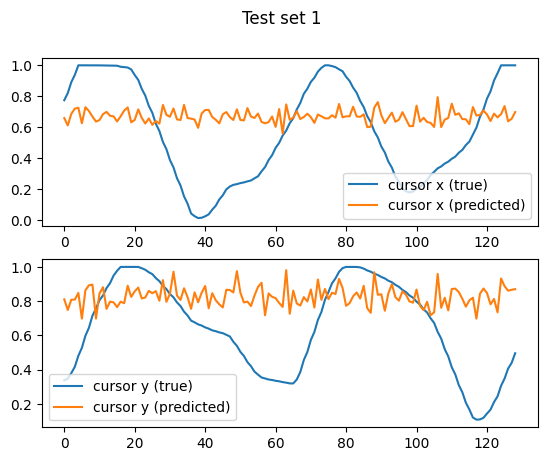

In [21]:
plt.figure(figsize=(10, 6))
fig, axs = plt.subplots(2)
fig.suptitle('Test set 1')
axs[0].plot(y_test_all[0][:,0])
axs[0].plot(y_pred_lstm_all[0][:,0])
axs[0].legend(['cursor x (true)', 'cursor x (predicted)'])
axs[1].plot(y_test_all[0][:,1])
axs[1].plot(y_pred_lstm_all[0][:,1])
axs[1].legend(['cursor y (true)', 'cursor y (predicted)'])


In [22]:
# accuracy
# Compare with previous RNN
# If the difference between the true and predicted cursor position is less than 0.1, it is considered as correct.
# The performance of previous RNN model is 54%

# x position
diff = [np.linalg.norm(y_pred_lstm_all[0][i,0] - y_test_all[0][i,0]) for i in range(len(y_test_all[0][:,0]))]
x_percentages = len(np.where(np.array(diff) < 0.1)[0])/len(diff)

# y position
diff = [np.linalg.norm(y_pred_lstm_all[0][i,1] - y_test_all[0][i,1]) for i in range(len(y_test_all[0][:,0]))]
y_percentages = len(np.where(np.array(diff) < 0.1)[0])/len(diff)

In [24]:
print(x_percentages)
print(y_percentages)

0.10852713178294573
0.24031007751937986
